In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

# Loading Daily Data

In [2]:
file = "SN_y_tot_V2.0.csv"
df = pd.read_csv(file, sep=';', header=None)
#Naming the columns
df.columns = ['Fraction_Year', 'Sunspot_Number', 'Std_Dev', 'Observations', 'Indicator']
df = df.loc[df["Sunspot_Number"] != -1] #removing missing values

# Convert fractional year to Date (taking only the fractional year column)
def fractional_year_to_date(fractional_year):
    year = int(fractional_year)  # Extract integer part as year
    fraction = fractional_year - year  # Decimal part as fraction of year
    month = int(fraction * 12) + 1  # Convert fraction to month (approx.)
    day = int((fraction * 12 - (month - 1)) * 30) + 1  # Estimate day in the month
    return pd.Timestamp(year=year, month=month, day=day)

#creating new dataframe and copying required columns from df with he column name ds=Date and y=Sunspot_number
df1 = pd.DataFrame()
df1['ds'] = df['Fraction_Year'].apply(fractional_year_to_date)
df1['y'] = df['Sunspot_Number']
df1.head()


,ds,y
0,1700-07-01,8.3
1,1701-07-01,18.3
2,1702-07-01,26.7
3,1703-07-01,38.3
4,1704-07-01,60.0


# Preprocess the data

In [3]:
df1['y'] += 1  # Add small constant to handle zeros
df1 = df1.dropna()  # Drop remaining invalid rows
df1 = df1[df1['ds'] >= '1900-01-01']

# Training the FBProphet Model and predecting for the future time

In [4]:
# Initialize Prophet Model
yearly_model = Prophet()

# Fit the model
yearly_model.fit(df1)

# Create future dataframe (1 year)
future_yearly = yearly_model.make_future_dataframe(periods=1, freq='Y')

# Predict
forecast_yearly = yearly_model.predict(future_yearly)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl11mj9nb/bkzdsrbh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl11mj9nb/7gowpiir.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88490', 'data', 'file=/tmp/tmpl11mj9nb/bkzdsrbh.json', 'init=/tmp/tmpl11mj9nb/7gowpiir.json', 'output', 'file=/tmp/tmpl11mj9nb/prophet_modelcenq_3jo/prophet_model-20241129172604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


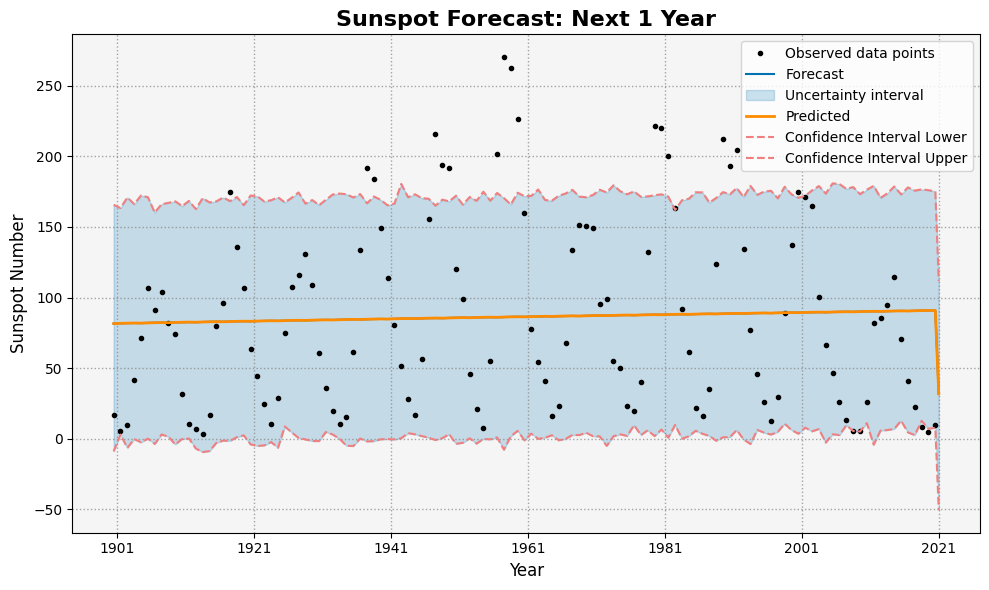

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


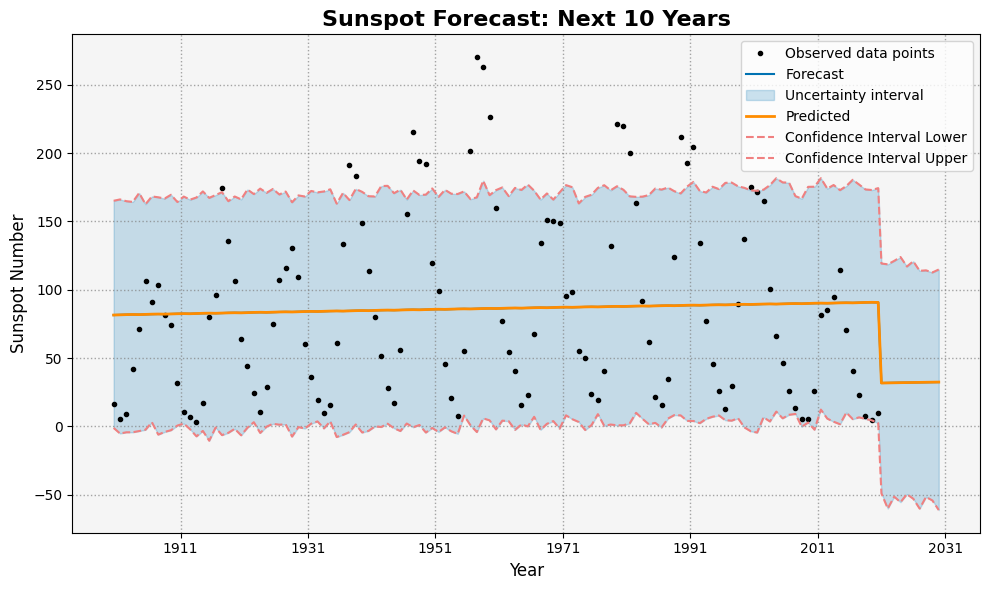

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


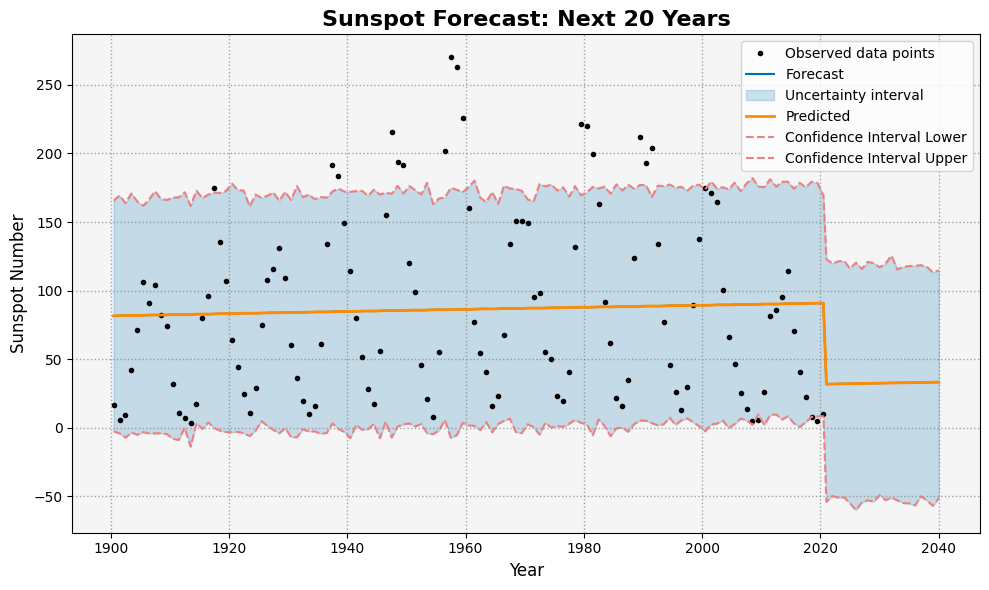

In [6]:
# Define a function to predict and plot forecasts for given periods
def predict_and_plot(model, periods, freq, title):

    # Create future dataframe
    future = model.make_future_dataframe(periods=periods, freq=freq)

    # Predict future data
    forecast = model.predict(future)

    # Plot the forecast with customizations
    fig = model.plot(forecast)

    # Customizing the plot for better visualization
    plt.title(title, fontsize=16, fontweight='bold')  # Title customization
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Sunspot Number", fontsize=12)

    # Customizing the line color and style
    plt.plot(forecast['ds'], forecast['yhat'], color='darkorange', linewidth=2, linestyle='-', label="Predicted")
    plt.plot(forecast['ds'], forecast['yhat_lower'], color='lightcoral', linestyle='--', label="Confidence Interval Lower")
    plt.plot(forecast['ds'], forecast['yhat_upper'], color='lightcoral', linestyle='--', label="Confidence Interval Upper")

    # Additional customizations
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)  # Customize grid style and transparency
    plt.legend()  # Show legend for the different lines
    plt.gca().set_facecolor('whitesmoke')  # Set the background color to a lighter shade
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

    return forecast

# Predict and plot for 1, 10, and 20 years
forecast_yearly_1 = predict_and_plot(yearly_model, 1, 'Y', "Sunspot Forecast: Next 1 Year")
forecast_yearly_10 = predict_and_plot(yearly_model, 10, 'Y', "Sunspot Forecast: Next 10 Years")
forecast_yearly_20 = predict_and_plot(yearly_model, 20, 'Y', "Sunspot Forecast: Next 20 Years")



In [7]:
# Define a function to display predictions
def display_predictions(forecast, periods, description):
    print(f"\nPredicted values for the next {periods} years ({description}):")
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods))

# Display predictions for 1, 10, and 20 years
display_predictions(forecast_yearly_1, 1, "1-year forecast")
display_predictions(forecast_yearly_10, 10, "10-year forecast")
display_predictions(forecast_yearly_20, 20, "20-year forecast")


Predicted values for the next 1 years (1-year forecast):
            ds     yhat  yhat_lower  yhat_upper
121 2020-12-31  31.7985  -50.493854  111.636036

Predicted values for the next 10 years (10-year forecast):
            ds       yhat  yhat_lower  yhat_upper
121 2020-12-31  31.798500  -48.893824  119.212454
122 2021-12-31  31.895309  -60.011188  118.632711
123 2022-12-31  31.986169  -51.335415  121.124948
124 2023-12-31  32.071046  -55.349083  123.973944
125 2024-12-31  32.095400  -49.526917  117.051767
126 2025-12-31  32.192209  -52.865901  120.851691
127 2026-12-31  32.283069  -60.060916  113.878120
128 2027-12-31  32.367946  -51.545390  114.220644
129 2028-12-31  32.392299  -54.107309  112.678051
130 2029-12-31  32.489109  -61.136977  114.842366

Predicted values for the next 20 years (20-year forecast):
            ds       yhat  yhat_lower  yhat_upper
121 2020-12-31  31.798500  -53.961842  122.890979
122 2021-12-31  31.895309  -49.748374  119.774410
123 2022-12-31  31.986169 

# vizualizing predictions

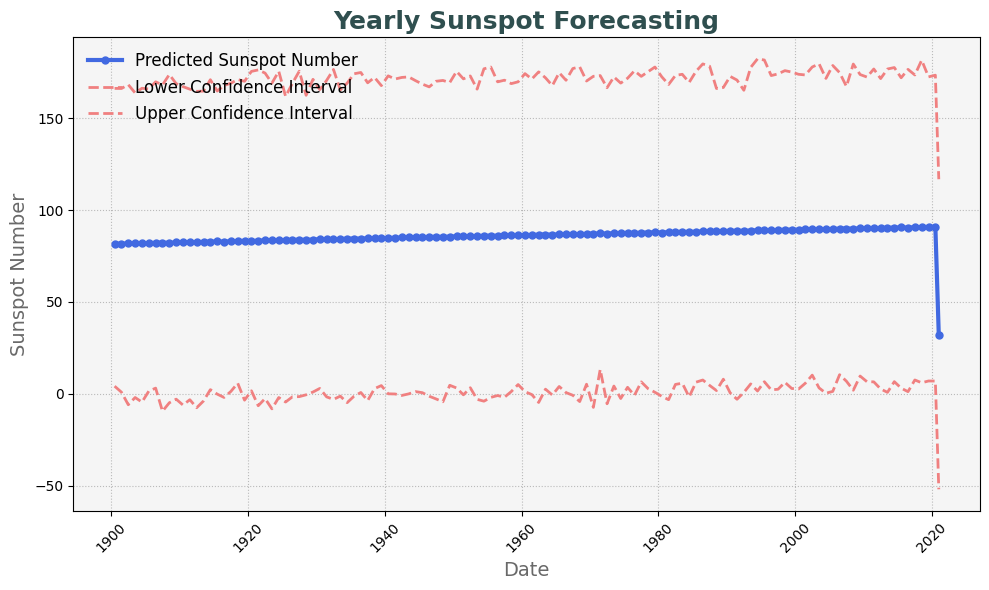

In [8]:
# Plot with a completely customized appearance
fig, ax = plt.subplots(figsize=(10, 6))  # Define figure size

# Plotting the predicted data with custom color and line style
ax.plot(forecast_yearly['ds'], forecast_yearly['yhat'], color='royalblue', linewidth=3, label='Predicted Sunspot Number', linestyle='-', marker='o', markersize=5)

# Plotting the confidence intervals with custom color and style
ax.plot(forecast_yearly['ds'], forecast_yearly['yhat_lower'], color='lightcoral', linestyle='--', label='Lower Confidence Interval', linewidth=2)
ax.plot(forecast_yearly['ds'], forecast_yearly['yhat_upper'], color='lightcoral', linestyle='--', label='Upper Confidence Interval', linewidth=2)

# Title and labels with custom font size and style
plt.title("Yearly Sunspot Forecasting", fontsize=18, fontweight='bold', color='darkslategray')
plt.xlabel("Date", fontsize=14, color='dimgray')
plt.ylabel("Sunspot Number", fontsize=14, color='dimgray')

# Customizing grid style
ax.grid(True, linestyle=':', color='gray', alpha=0.5)

# Customizing background color
ax.set_facecolor('whitesmoke')

# Adding a legend with customized font style
ax.legend(loc='upper left', fontsize=12, frameon=False)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot with tight layout to avoid clipping of labels
plt.tight_layout()
plt.show()


# Tune Hyperparameters : Adding custom seasonality

In [10]:
from prophet import Prophet

# Define a more customized Prophet model
yearly_model = Prophet(
    growth='linear',  # Linear growth, but you can change to 'logistic' if you want logistic growth
    changepoint_prior_scale=0.1,  # Increased changepoint prior scale for more flexibility
    seasonality_prior_scale=15,   # Higher seasonality prior scale for stronger seasonality effects
    seasonality_mode='multiplicative',  # Use multiplicative seasonality (use 'additive' for additive seasonality)
    yearly_seasonality=False,  # Disable the default yearly seasonality (you will define your custom seasonalities)
    weekly_seasonality=False,  # Disable weekly seasonality
    daily_seasonality=False   # Disable daily seasonality
)

# Add custom seasonality for solar cycles
yearly_model.add_seasonality(name='solar_cycle', period=11, fourier_order=7)  # 11-year solar cycle, adjusted Fourier order
yearly_model.add_seasonality(name='half_solar_cycle', period=5.5, fourier_order=4)  # Half solar cycle with adjusted Fourier order

# Fit the model on the dataset
yearly_model.fit(df1)

# Predict future data using the trained model
forecast_yearly = yearly_model.predict(future_yearly)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpl11mj9nb/t2jim6j5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl11mj9nb/g1l2tr_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27265', 'data', 'file=/tmp/tmpl11mj9nb/t2jim6j5.json', 'init=/tmp/tmpl11mj9nb/g1l2tr_4.json', 'output', 'file=/tmp/tmpl11mj9nb/prophet_model9or7skj_/prophet_model-20241129172744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


C:\Users\All\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


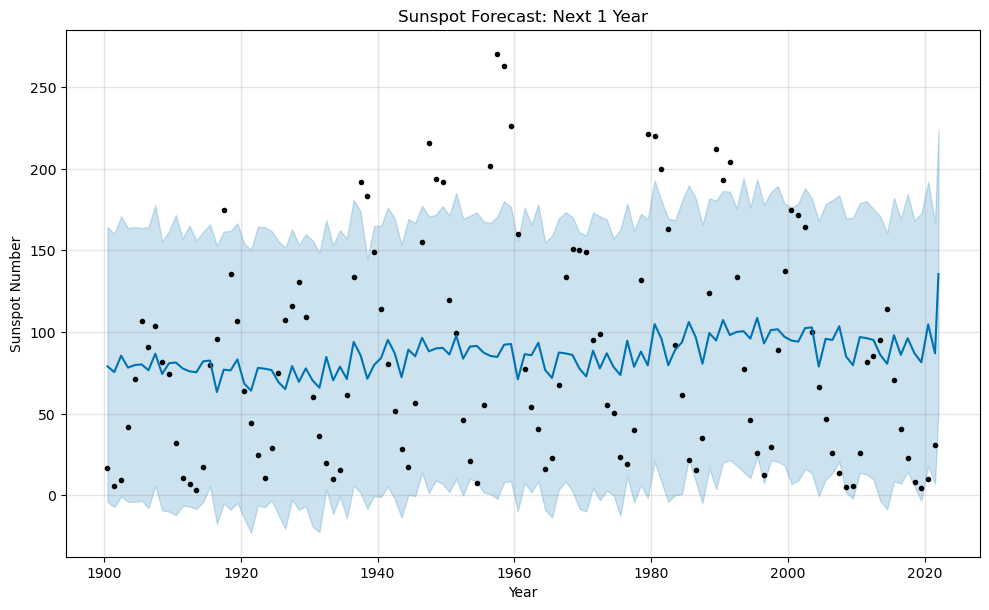

C:\Users\All\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


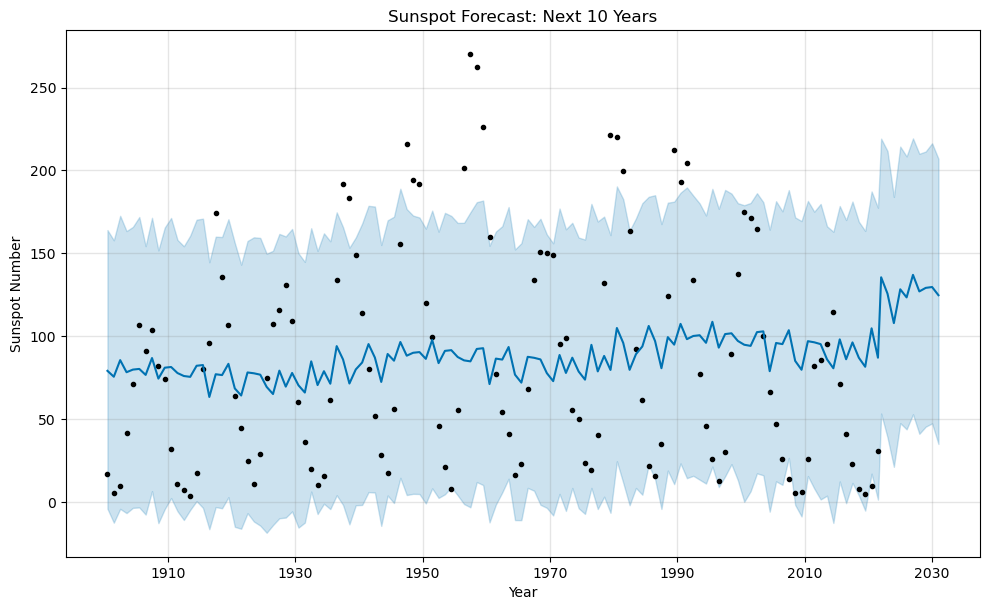

C:\Users\All\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


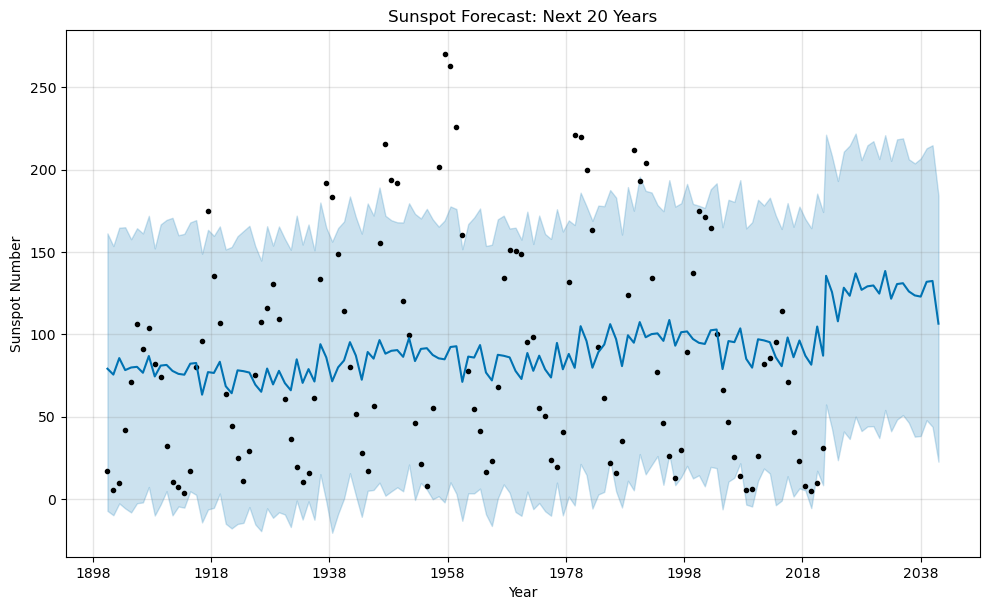

In [ ]:
# Predict and plot for 1, 10, and 20 years
forecast_yearly_1 = predict_and_plot(yearly_model, 1, 'Y', "Sunspot Forecast: Next 1 Year")
forecast_yearly_10 = predict_and_plot(yearly_model, 10, 'Y', "Sunspot Forecast: Next 10 Years")
forecast_yearly_20 = predict_and_plot(yearly_model, 20, 'Y', "Sunspot Forecast: Next 20 Years")

In [ ]:
# Display predictions for 1, 10, and 20 years
display_predictions(forecast_yearly_1, 1, "1-year forecast")
display_predictions(forecast_yearly_10, 10, "10-year forecast")
display_predictions(forecast_yearly_20, 20, "20-year forecast")


Predicted values for the next 1 years (1-year forecast):
            ds        yhat  yhat_lower  yhat_upper
122 2021-12-31  135.503082   52.159252  223.475191

Predicted values for the next 10 years (10-year forecast):
            ds        yhat  yhat_lower  yhat_upper
122 2021-12-31  135.503082   53.266565  219.181564
123 2022-12-31  125.614336   38.844789  211.692581
124 2023-12-31  107.834519   21.082840  183.987143
125 2024-12-31  128.250916   47.463375  214.385932
126 2025-12-31  123.361239   43.716902  208.441447
127 2026-12-31  136.962764   52.816893  219.328858
128 2027-12-31  126.966533   41.025565  210.034396
129 2028-12-31  129.108765   45.330124  211.420674
130 2029-12-31  129.621374   47.314243  216.384567
131 2030-12-31  124.678563   34.900083  207.014775

Predicted values for the next 20 years (20-year forecast):
            ds        yhat  yhat_lower  yhat_upper
122 2021-12-31  135.503082   57.308362  221.237237
123 2022-12-31  125.614336   42.575927  208.281892
124 20

In [ ]:
# Evaluate using proper y_true and y_pred alignment
y_true = df1['y']
y_pred = forecast_yearly['yhat'][:len(y_true)]

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}, MAPE: {mape:.2f}, R²: {r2:.3f}")

MAE: 55.37, MAPE: 2.14, R²: 0.020
